# Assignment 6: Continuous-time discrete models

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

# General instructions

1. Do not remove any text or code cells; do not leave redundent print messages.
1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 4 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. Your code should run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, numba, multiprocessig.
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment6"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import solve_ivp
import seaborn as sns
sns.set_context('notebook')
red, blue, green, purple, orange, yellow = sns.color_palette('Set1', 6)

# Background

Recall our work on the predator-prey model:

In [2]:
def dxydt(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array([dx, dy])

In [3]:
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 50000
XY = np.empty((2, steps))
XY[:,0] = 50, 100
dt = 0.001

for t_ in range(1, steps):
    XY[:,t_] = XY[:, t_-1] + dxydt(t_, XY[:, t_-1], b, h, ϵ, d) * dt
X, Y = XY
T = np.arange(0, steps*dt, dt)

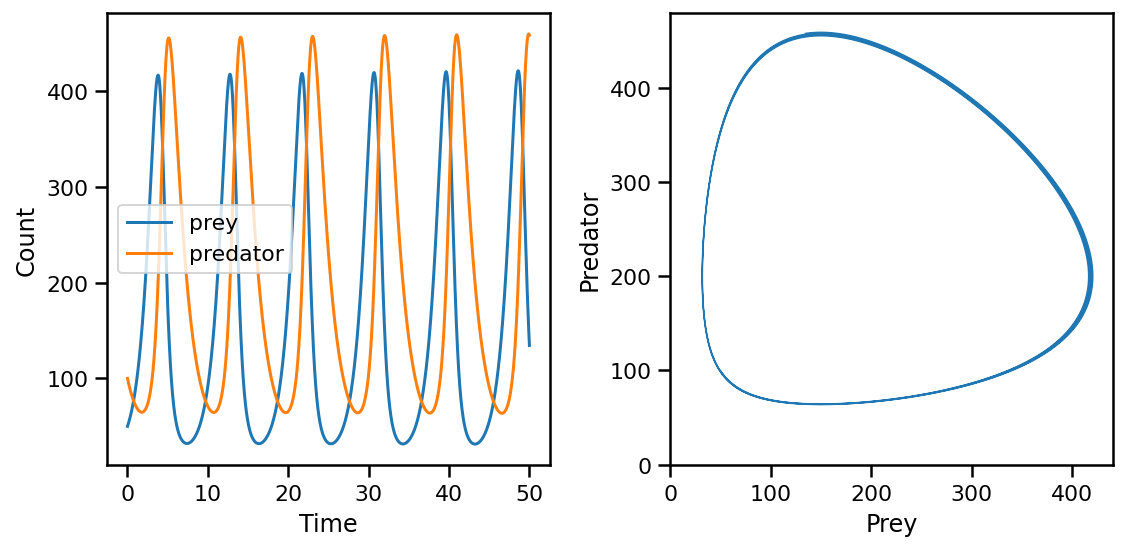

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(T, X, label='prey')
ax.plot(T, Y, label='predator')
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.legend();

ax = axes[1]
ax.plot(X, Y, lw=0.5)
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')
ax.set(xlim=(0, None), ylim=(0, None))

fig.tight_layout()

We talked about how these cycles only *seem* stable, but really, they are prone to extinctions due to stochastic events, leading to either exitinction of both species or extinction of the predator and explosion of the prey population.

In this assignment you will implement a stochastic simulation of the dynamics using Gillespie's algorithm, which we covered in lecture 10.

The following is a table of reactions and their rates for the predator-prey dynamics.

$x$ denote the prey, $y$ denotes the predator; use the same rates as used in the deterministic model: $b$, $h$, $\epsilon$, and $d$.

Note that $h$ describes the rate at which predators hunts prey, whereas $\epsilon$ described the rate at which predators convert prey mass into predator mass.
We didn't have a scenario like that in the molecular dynamics case and it requires a bit of sophistication.

$$\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } a_i \\
x \rightarrow x+1,\;\;\;\; & bx \\
x \rightarrow x-1, \;\;\;\; & (1-\epsilon) hxy \\
x, y \rightarrow x-1, y+1, \;\;\;\; &  \epsilon h x y \\
y \rightarrow y-1, \;\;\;\; & dy.
\end{array}
\end{align}
$$

# Ex 1 

**Write a Gillespie simulation for the predator-prey dynamics.**

**Run a single simulation and plot it together with the deterministic dynamics.**

Note that once the predators are extinct there is no more use to continue running the simulation as the prey will just grow exponentiallt according to $dx/dt = bx$.

In [13]:
def get_rates(x, y, b, h, ϵ, d):
    return np.array([
        b * x,  
        (1 - ϵ) * h * x * y,
        ϵ * h * x * y,
        d * y  
    ])

In [14]:
def draw_time(rates):
    assert rates.sum() > 0, rates
    total_rate = rates.sum()
    return np.random.exponential(1/total_rate)

In [15]:
def draw_reaction(rates):
    assert rates.sum() > 0, rates
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

In [16]:
updates = np.array([
    [1, 0],  # prey born
    [-1, 0], # prey killed, no predator born
    [-1, 1], # prey killed, predator born
    [0, -1]  # predator killed
])

In [17]:
def gillespie_step(x, y, b, h, ϵ, d):
    rates = get_rates(x, y, b, h, ϵ, d)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δx, Δy = updates[ri]
    return Δt, Δx, Δy

In [18]:
def gillespie_ssa(b, h, ϵ, d, t0=0, x0=X[0], y0=Y[0], t_steps=steps, tmax=steps*dt):
    times = np.linspace(t0, tmax, t_steps)
    states = np.zeros((updates.shape[1], t_steps), dtype=int) 
    
    t = t0
    x, y = x0, y0
    Δx, Δy = 0, 0

    for i, next_t in enumerate(times):
        while t < next_t:
            Δt, Δx, Δy = gillespie_step(x, y, b, h, ϵ, d)
            t, x, y = t+Δt, x+Δx, y+Δy
            if x == 0 or y == 0:
                break
        states[:, i] = x - Δx, y - Δy
        if x == 0 or y == 0:
            break
    return np.concatenate((times.reshape(1, -1), states), axis=0)

In [11]:
%%time
t, x, y = gillespie_ssa(b, h, ϵ, d)

CPU times: user 1.04 s, sys: 8.46 ms, total: 1.05 s
Wall time: 1.06 s


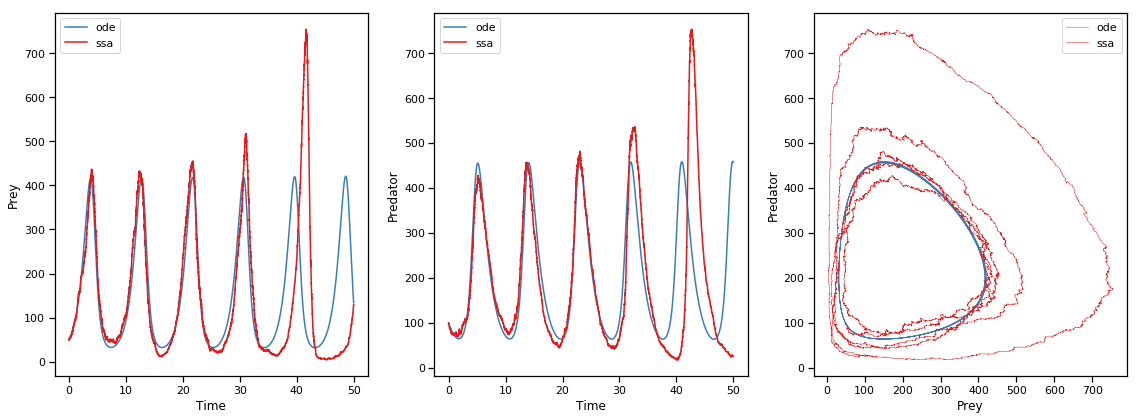

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

ax = axes[0]
ax.plot(T, X, color=blue, label='ode')
ax.plot(t, x, color=red, label='ssa')
ax.set_xlabel('Time')
ax.set_ylabel('Prey')
ax.legend()

ax = axes[1]
ax.plot(T, Y, color=blue, label='ode')
ax.plot(t, y, color=red, label='ssa')
ax.set_xlabel('Time')
ax.set_ylabel('Predator')
ax.legend()

ax = axes[2]
ax.plot(X, Y, lw=0.5, color=blue, label='ode')
ax.plot(x, y, lw=0.5, color=red, label='ssa')
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')
ax.legend()

fig.tight_layout()

# Ex 2

**Calculate the extinction probability of the predators in the first 50 days (assuming `t` is in days) and plot it as a function of $h$ the hunting probability.**

The extinction probability is the probability that the predators populations size reaches zero.
To do that, you will have to run many simulations for the same parameters and check what is the fraction that finished with zero predators.

Think: How many replications should you use per parameter set?
Remember that the standard error of the mean generally decreases like the root of the number of observations ($\sqrt{n}$).

When choosing the number of $h$ values, think if you want to use `np.linspace` or `np.logspace`, or maybe draw random values (from which distribution?) and how many points you should use.

Note that this exercise will require running many simulations; if we estimate the probability from just 100 simulations, and plot against just 10 values of $h$, we still need to run 1000 simulations.

There are several ways to attack this, and they are not mutually exclusive:
1. optimize the simulation code
1. run in parallel on multiple cores on your own machine (see end of lecture 10).
1. use cloud computing on your own (see end of lecture 10).
1. use the [course's cloud computing](https://scicompy-jupyter.yoavram.com) as explained in class. Remember that this is a shared resource for all course participants, so try to use it when it is free.

At any case, make sure to save your simulation results to files so that you can reload them again and change the analysis or plot the figure again (but do not include these files in the assignment submission).

In [26]:
def extinction_probability(b, h, ϵ, d, x0=X[0], y0=Y[0], reps=500):
    txy = np.array([
        gillespie_ssa(b, h, ϵ, d, x0=x0, y0=y0, tmax=50) 
        for _ in range(reps)
    ])
    y = txy[:, 2, :]
    return (y[:,-1]==0).mean()

In [14]:
%%time
hs = np.logspace(-3, 0, 30)
ps = np.array([extinction_probability(b, h_, ϵ, d) for h_ in hs])

CPU times: user 1h 23min 29s, sys: 24.5 s, total: 1h 23min 54s
Wall time: 1h 23min 49s


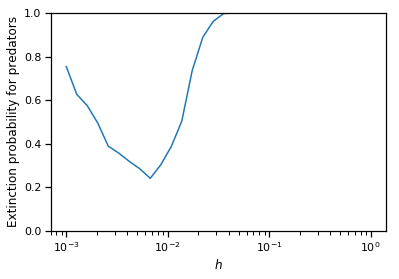

In [15]:
plt.plot(hs, ps)
plt.xlabel('$h$')
plt.ylabel('Extinction probability for predators')
plt.ylim(0, 1)
plt.xscale('log');

# Ex 3

Here's data from a real predator-prey system -- the hare and lynx system:

In [19]:
data = np.fromstring("""0 20 10 
2 55 15 
4 65 55 
6 95 60 
8 55 20 
10 5 15 
12 15 10 
14 50 60 
16 75 60 
18 20 10 
20 25 5 
22 50 25 
24 70 40 
26 30 25 
28 15 5 
""", sep=' ', dtype=int)
data = data.reshape(-1, 3)
data[:, 1] *= 1000
data[:, 2] *= 100
print(data)

[[    0 20000  1000]
 [    2 55000  1500]
 [    4 65000  5500]
 [    6 95000  6000]
 [    8 55000  2000]
 [   10  5000  1500]
 [   12 15000  1000]
 [   14 50000  6000]
 [   16 75000  6000]
 [   18 20000  1000]
 [   20 25000   500]
 [   22 50000  2500]
 [   24 70000  4000]
 [   26 30000  2500]
 [   28 15000   500]]


The first column is years, the second is hare population size, the third is lynx population size.

Let's plot the data.

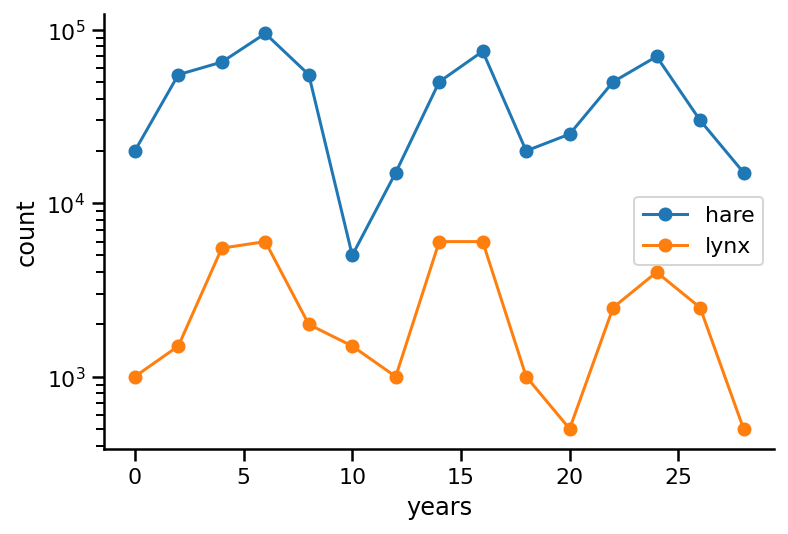

In [20]:
t, hare, lynx = data.T

plt.plot(t, hare, '-o', label='hare')
plt.plot(t, lynx, '-o', label='lynx')
plt.yscale('log')
plt.xlabel('years')
plt.ylabel('count')
plt.legend()

sns.despine()

We can see the cycles that we discussed in lecture 8.

**Now use ABC to fit a model to the data**, just as we did in lecture 10.

You don't have to use use summary statistics, rather, you may compute the MAE (mean absolute error) between the data and the simulations.
The `ABCSMC` constructor's third argument is a distance function that accepts the simulation dict as a first argument and the real dict as a second argument (the real dict is the observations dictionary you give to the `new` method later on). See [example](https://pyabc.readthedocs.io/en/latest/examples/parameter_inference.html).

**Tips**
- for `b` and `d` choose an `halfnorm(1)` prior distribution
- for `h` and `ϵ` choose `uniform(0, 1)` prior distribution
- if you get division by zero errors, the population has probably gone extinct, you should make sure you stop the simulation when the population is extinct
- running time may vary, but will take at least several minutes and even hours
- the printed values below are random

In [21]:
import pyabc

In [22]:
priors = pyabc.Distribution(
    b=pyabc.RV("halfnorm", 1), 
    h=pyabc.RV("uniform", 0, 1),
    ϵ=pyabc.RV("uniform", 0, 1),
    d=pyabc.RV("halfnorm", 1)
)
priors.rvs()

<Parameter 'b': 1.3868594137590804, 'h': 0.9461334791285713, 'ε': 0.700576955743126, 'd': 1.469252269624338>

In [23]:
def model(params):
    t_, hare_, lynx_ = gillespie_ssa(**params, 
                                    t0=t[0], x0=hare[0], y0=lynx[0], 
                                    tmax=t[-1]-t[0], t_steps=t.size)
    return dict(
        hare=hare_,
        lynx=lynx_
    )
model(priors.rvs())

{'hare': array([2.e+04, 1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00]),
 'lynx': array([ 1000., 11942.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.])}

In [24]:
def distance_hare(x, y):
    diff = x['hare'] - y['hare']
    return np.mean(diff * diff)
                   
def distance_lynx(x, y):
    diff = x['lynx'] - y['lynx']
    return np.mean(diff * diff)


distance = pyabc.AdaptiveAggregatedDistance(
    [distance_hare, distance_lynx]
)

observation = dict(hare=hare, lynx=lynx)
distance_adaptive(model(priors.rvs()), observation)

2499607450.8

In [31]:
abc = pyabc.ABCSMC(
    model, 
    priors,
    distance_adaptive,
    population_size=1000,
#     sampler=pyabc.SingleCoreSampler() # only needed on Mac
)
db_path = "sqlite:///pyabc_hare_lynx.db"

INFO:Sampler:Parallelizing the sampling on 56 cores.


In [32]:
abc_id = abc.new(db_path, observation)

INFO:History:Start <ABCSMC(id=2, start_time=2020-06-15 14:58:58.905505, end_time=None)>


In [33]:
history = abc.run(min_acceptance_rate=0.05)

INFO:ABC:Calibration sample before t=0.
ABCSMC ID <pyabc.storage.history.History object at 0x7fb2efeb2eb0>
INFO:Epsilon:initial epsilon is 12.42726917351892
INFO:ABC:t: 0, eps: 12.42726917351892.
INFO:ABC:Acceptance rate: 1000 / 2047 = 4.8852e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 4.119030105418587.
INFO:ABC:Acceptance rate: 1000 / 2293 = 4.3611e-01, ESS=7.7284e+02.
INFO:ABC:t: 2, eps: 7.018251423449151.
INFO:ABC:Acceptance rate: 1000 / 2026 = 4.9358e-01, ESS=5.1664e+02.
INFO:ABC:t: 3, eps: 4.261347602667588.
INFO:ABC:Acceptance rate: 1000 / 2377 = 4.2070e-01, ESS=8.1882e+02.
INFO:ABC:t: 4, eps: 4.549125904966311.
INFO:ABC:Acceptance rate: 1000 / 2095 = 4.7733e-01, ESS=2.2127e+01.
INFO:ABC:t: 5, eps: 3.815249117080216.
INFO:ABC:Acceptance rate: 1000 / 4155 = 2.4067e-01, ESS=6.2002e+02.
INFO:ABC:t: 6, eps: 3.473328833727721.
INFO:ABC:Acceptance rate: 1000 / 2561 = 3.9047e-01, ESS=1.2961e+02.
INFO:ABC:t: 7, eps: 3.797745441570779.
INFO:ABC:Acceptance rate: 1000 / 11764 = 8.5005e-02, ES

In [26]:
abc.load('sqlite:///pyabc_hare_lynx.db', 2)
history = abc.history

**Print the point estimates of the model parameters**.

In [27]:
samples, weights = history.get_distribution(m=0)
params_hat = np.average(samples, weights=weights, axis=0)

print("b_hat = {:.3f}\nh_hat = {:.3f}\nε_hat = {:.3f}\nd_hat = {:.3f}".format(*params_hat))

b_hat = 1.822
h_hat = 1.794
ε_hat = 0.081
d_hat = 0.074


**Plot the approximated posterior distributions** of the model parameters.

In [28]:
from pyabc.visualization import plot_kde_matrix_highlevel

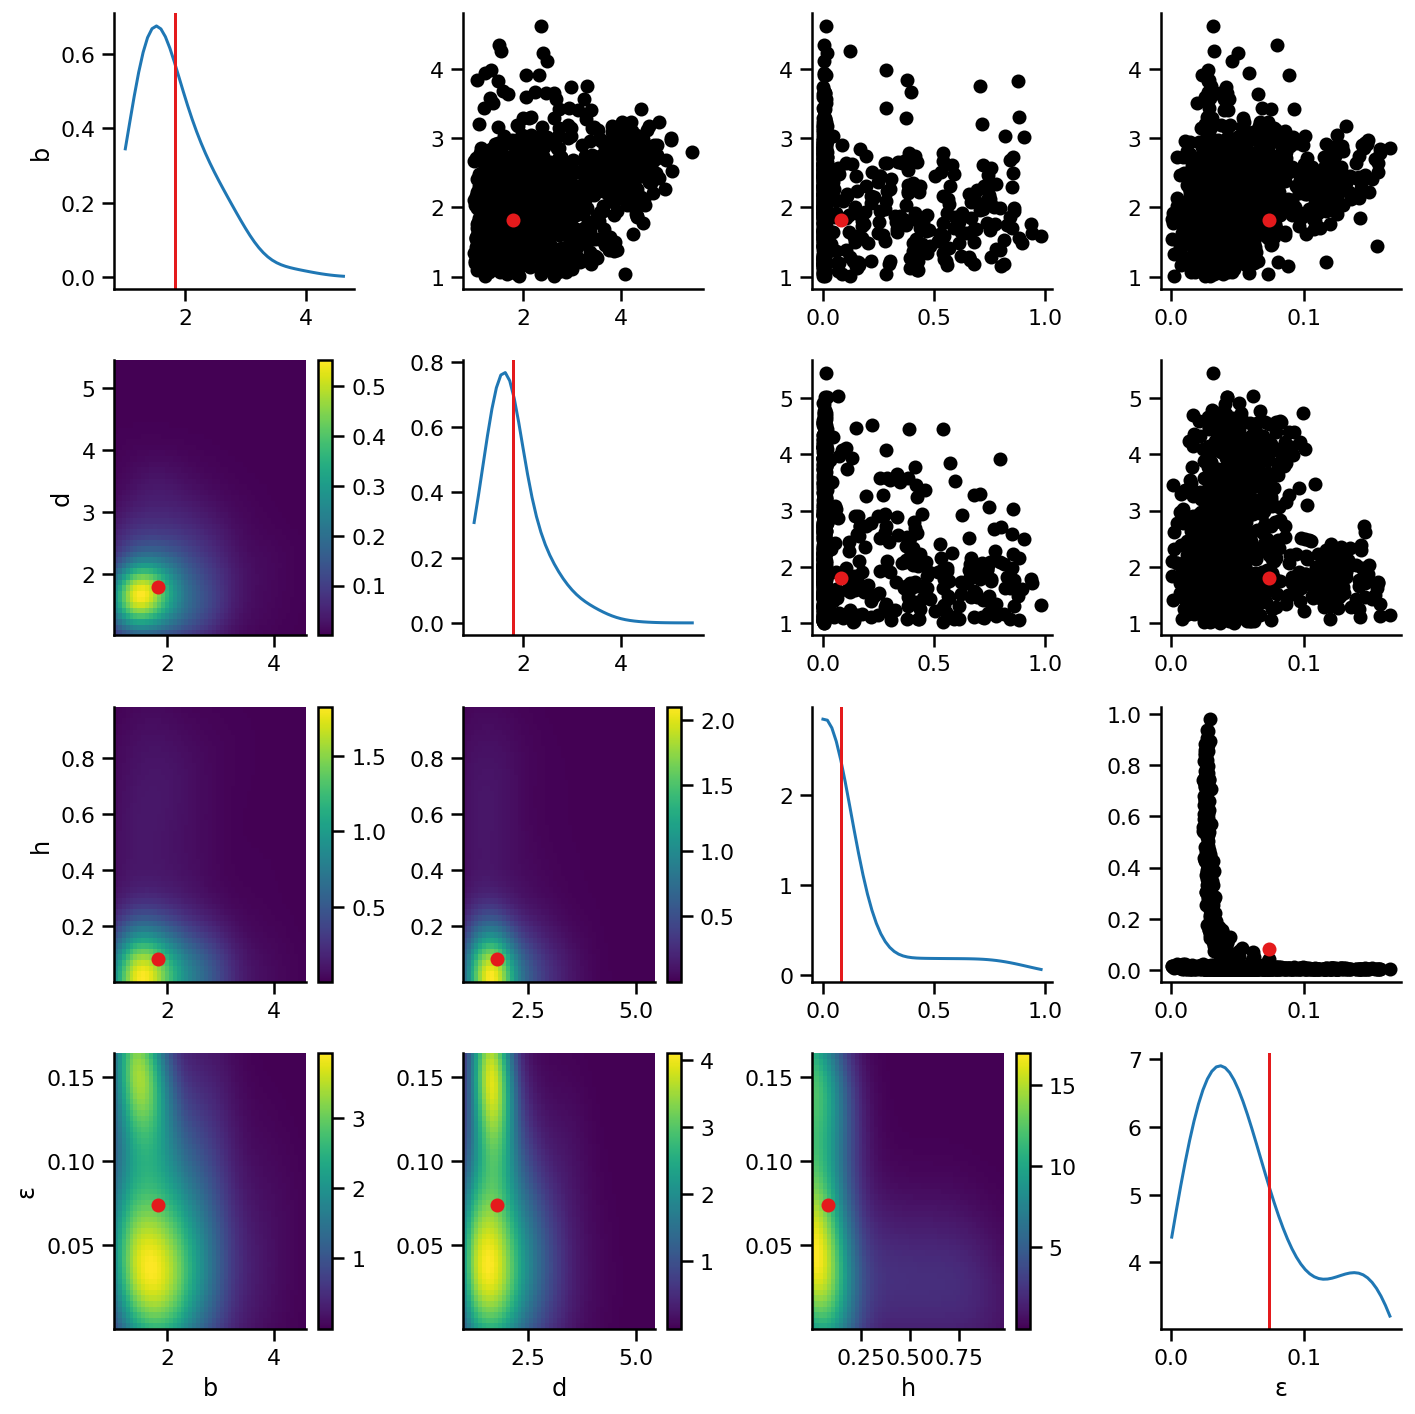

In [29]:
axes = plot_kde_matrix_highlevel(
    history, 
)
for i in range(4):
    axes[i,i].axvline(params_hat[i], color=red)
    for j in range(4):
        if i == j: continue
        axes[j,i].plot(params_hat[i],params_hat[j], 'o', color=red)

**end of assignment**